# Multifractal Detrended Moving Average (MF-DMA) Module

Reference:

Gu, Gao-Feng Gu, and Wei-Xing Zhou. "Detrending moving average algorithm for multifractals." Physical Review E, no. 82, 2010, pp. 011136,

Arianos, Sergio, and Anna Carbone. "Detrending moving average algorithm: A closed-form approximation of the scaling law." Physica A, no. 382, 2007, pp. 9–15

In [1]:
import array
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
files = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/SPX_1m_Dec2020_Jun2023.csv'

df = pd.read_csv(files)
# Set timestamp as index
df = df.set_index(df['Time'])
df.drop(['Time'], axis=1, inplace=True)
df.index = pd.to_datetime(df.index)

# Calculate log return
df['log_ret'] = 10000 * np.log(df.Price).diff() # 10,000 times log return

# Calculate the time difference in mininutes
df['deltaT'] = (df.index.to_series().diff().dt.days.mul(60*24, fill_value=0) +
                df.index.to_series().diff().dt.seconds.div(60, fill_value=0)
               )

df_1min = df[df['deltaT'] == 1]
df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])
df_1min

C:\Users\cutef\AppData\Local\Temp\ipykernel_1300\374198705.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])


,Price,log_ret,deltaT,log_ret_sq
Time,,,,
2020-12-01 00:01:00,3654.045,1.932292,1.0,3.733753
2020-12-01 00:02:00,3654.336,0.796346,1.0,0.634167
2020-12-01 00:03:00,3653.945,-1.070019,1.0,1.144941
2020-12-01 00:04:00,3653.845,-0.273681,1.0,0.074901
2020-12-01 00:05:00,3653.299,-1.494428,1.0,2.233315
...,...,...,...,...
2023-06-30 16:09:00,4446.311,-1.171689,1.0,1.372856
2023-06-30 16:10:00,4445.570,-1.666689,1.0,2.777852
2023-06-30 16:11:00,4445.332,-0.535379,1.0,0.286630


## 1. Construct the sequence of cumulative sums

<AxesSubplot:xlabel='Time'>

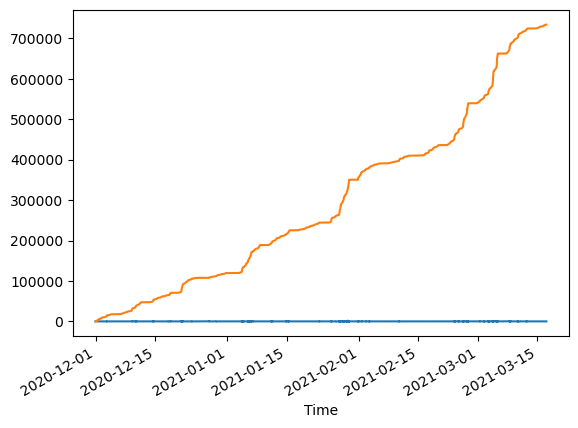

In [3]:
n_sample = 60 * 24 * 22 * 3 # sample is 3-month-equivalent dataset

cs = pd.DataFrame(df_1min['log_ret_sq'][:n_sample], columns = ['log_ret_sq'])
cs['cum_sum'] = cs['log_ret_sq']
cs['cum_sum'] = cs['cum_sum'].cumsum()

cs['log_ret_sq'].plot()
cs['cum_sum'].plot()

In [4]:
cs

,log_ret_sq,cum_sum
Time,,
2020-12-01 00:01:00,3.733753,3.733753
2020-12-01 00:02:00,0.634167,4.367920
2020-12-01 00:03:00,1.144941,5.512860
2020-12-01 00:04:00,0.074901,5.587761
2020-12-01 00:05:00,2.233315,7.821076
...,...,...
2021-03-17 02:25:00,1.518706,734155.463935
2021-03-17 02:26:00,0.286569,734155.750504
2021-03-17 02:27:00,0.573778,734156.324282


## In the for-loop:
### 2. Calculate moving average
### 3. Detrend
### 4. Define non-overlapping segments and calculate each fluctuation variance
### 5. Calculate q-th order fluctuation function

In [7]:
# Define parameters
lags = np.unique(np.logspace(0.5, 3, 50).astype(int))
qs = [-10, -7, -5, -3, -2, 2, 3, 5, 7, 10]
total_epoch = len(lags) * len(qs)
len_total = len(cs['cum_sum'])

# Create DMA flucuation function dataframe
F_summary_columns = []
for q in qs:
    F_summary_columns.append('q_'+str(q))

F_summary_index = []
for l in lags:
    F_summary_index.append('n_'+str(l))

F_summary = pd.DataFrame(index=F_summary_index, columns=F_summary_columns)

In [8]:
print(f'Total epochs is {total_epoch}, estimated time is {int(total_epoch/6/6)} min') # spend 10 sec per 6 epochs
starttime_total = time.time()
starttime_epoch = time.time()

epoch = 0
for lag in lags:
    mean_temp = []
    # Calculate moving average
    for i in range(len(cs['cum_sum'])-lag+1):
        mean_temp.append(np.mean(cs['cum_sum'][i:i+lag]))
    mean_temp.reverse()

    # Detrend
    diff_temp_subtractor = cs['cum_sum'][:lag-2:-1].values
    diff_temp = np.subtract(np.array(mean_temp), diff_temp_subtractor)

    # Slice into non-overlapping segments
    segs_temp = pd.DataFrame(np.resize(diff_temp, (len(diff_temp) // lag, lag))).T

    # Calculate fluctuation variance
    F_seg_sq_temp = np.array(np.var(segs_temp).mean(axis=0)) 

    for q in qs:
        # Calculate the qth order fluctuation function
        F_temp =  ((1 / lag) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
        F_summary.loc[str('n_'+str(lag))][str('q_'+str(q))] = F_temp
        epoch += 1
        
    print(f'Epoch {epoch} is done')
        
endtime_total = time.time()        
total_time = endtime_total - starttime_total
print(f'Total time spent is {int((endtime_total-starttime_total)//60)} min {int((endtime_total-starttime_total) % 60)} sec(s)')

Total epochs is 470, estimated time is 13 min
Epoch 10 is done
Epoch 20 is done
Epoch 30 is done
Epoch 40 is done
Epoch 50 is done
Epoch 60 is done
Epoch 70 is done
Epoch 80 is done
Epoch 90 is done
Epoch 100 is done
Epoch 110 is done
Epoch 120 is done
Epoch 130 is done
Epoch 140 is done
Epoch 150 is done
Epoch 160 is done
Epoch 170 is done
Epoch 180 is done
Epoch 190 is done
Epoch 200 is done
Epoch 210 is done
Epoch 220 is done
Epoch 230 is done
Epoch 240 is done
Epoch 250 is done
Epoch 260 is done
Epoch 270 is done
Epoch 280 is done
Epoch 290 is done
Epoch 300 is done
Epoch 310 is done
Epoch 320 is done
Epoch 330 is done
Epoch 340 is done
Epoch 350 is done
Epoch 360 is done
Epoch 370 is done
Epoch 380 is done
Epoch 390 is done
Epoch 400 is done
Epoch 410 is done
Epoch 420 is done
Epoch 430 is done
Epoch 440 is done
Epoch 450 is done
Epoch 460 is done
Epoch 470 is done
Total time spent is 9 min 47 sec(s)


In [9]:
F_summary

,q_-10,q_-7,q_-5,q_-3,q_-2,q_2,q_3,q_5,q_7,q_10
n_3,15.671339,16.426845,17.491145,20.250437,24.319498,8.106499,9.735395,11.271189,12.001452,12.580035
n_4,20.414658,21.664301,23.450284,28.211279,35.543984,8.885996,11.195653,13.468651,14.578993,15.471418
n_5,24.242208,25.973353,28.475356,35.291098,46.148774,9.229755,12.069386,14.958263,16.399187,17.570259
n_6,27.049781,29.208758,32.357792,41.089644,55.389094,9.231516,12.44414,15.80223,17.505889,18.903121
n_7,30.207282,32.83448,36.696231,47.5665,65.788634,9.398376,12.998777,16.849315,18.831008,20.468784
n_8,33.143177,36.232474,40.804037,53.841249,76.143025,9.517878,13.460312,17.760989,20.001947,21.866342
n_9,37.044903,40.702827,46.147982,61.856459,89.212451,9.912495,14.296291,19.162656,21.726204,23.871514
n_10,39.063572,43.11507,49.178124,66.850597,98.123257,9.812326,14.402525,19.578164,22.331342,24.647448
n_11,43.68249,48.410382,55.519642,76.436187,113.989399,10.362673,15.453869,21.275981,24.400445,27.04138
n_12,45.483257,50.594368,58.313576,81.219537,122.892124,10.24101,15.495527,21.582273,24.875091,27.670391


## 6. Calculate Hurst exponent

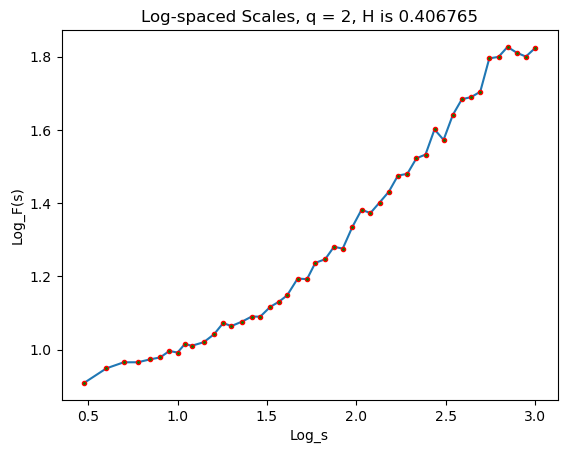

In [10]:
# Log-log plot and calculate H
log10_lag = np.log10(lags)
log10_F = np.log10(np.array(F_summary['q_2']).astype(float)) 
hurst_hat = np.polyfit(log10_lag, log10_F, 1)[0]

plt.plot(log10_lag, log10_F, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="green") 
plt.xlabel('Log_s')
plt.ylabel('Log_F(s)')
plt.title('Log-spaced Scales, q = 2, H is '+ f'{hurst_hat:2f}')
plt.show()